In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Generic Packages
import numpy as np
import os
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd

#Plotting Libraries
import seaborn as sn; sn.set(font_scale=1.4)
import matplotlib.pyplot as plt

#openCV
import cv2

#Tensor Flow
import tensorflow as tf

#Display Progress
from tqdm import tqdm

from skimage.transform import resize
from skimage.io import imread
from sklearn.model_selection import train_test_split


from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers

In [3]:
### 사용자 정의 함수
%cd /content/drive/MyDrive/project3

# Add the paths to the modules to the Python path
import sys
sys.path.append(os.path.abspath('./code/image_function'))

from image_load import resize_image, load_image, load_and_resize_images
from vram_reset import reset_vram

/content/drive/.shortcut-targets-by-id/1gdU-KuXDUU7v2o8X7TdV0JgGiz603mCc/project3


In [4]:
def load_image(datadir,img_new_size, pic_new_cnt) :

  food_middle_list = sorted(os.listdir(datadir)) # 중분류
  food_list = [] # 음식이름
  food_path_list = [] # 음식이름 경로

  for food_middle in food_middle_list:
    middle_path = os.path.join(datadir,food_middle)
    food_name_list = os.listdir(middle_path)

    for food in food_name_list:
        path = os.path.join(middle_path,food)
        food_path_list.append(path)

        name = path.split('/')[-1]
        food_list.append(name)

  image_li, target_li, except_li = load_and_resize_images(food_path_list, food_list, img_size = img_new_size, pic_cnt = pic_new_cnt)

  return image_li, target_li, except_li

image_li, target_li, except_li = load_image('/content/drive/MyDrive/project3/data/traindata/output_image_color',(224,224),100)

Processing images: 100%|██████████| 2/2 [00:25<00:00, 12.95s/it]


In [5]:
def preprocessing_image(image_list, target_list):

  # 카테고리랑 숫자로 바꾼 값 dict형태로 만들기
  categories_label = {category:i for i, category in enumerate(np.unique(target_list))}
  # target값을 숫자로 변형
  target_num = np.array([categories_label[category] for category in target_list], dtype=np.int8)

  X_train, X_test, y_train, y_test = train_test_split(image_list, target_num, test_size=0.2, random_state=42 )

  # 정규화
  X_train = X_train / 255.0
  X_test = X_test / 255.0

  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocessing_image(image_li, target_li)

In [6]:
# ResNet50 model
resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet_50.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [7]:
# build the entire model
x = resnet_50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(2, activation='softmax')(x)
model = Model(inputs = resnet_50.input, outputs = predictions)

In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [9]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = model.fit(X_train,y_train, epochs = 20,validation_split = 0.2)

Epoch 1/20
4/4 [==============================] - 15s 1s/step - loss: 1.2799 - accuracy: 0.5185 - val_loss: 0.7162 - val_accuracy: 0.4074
Epoch 2/20
4/4 [==============================] - 0s 130ms/step - loss: 0.9449 - accuracy: 0.5556 - val_loss: 0.6849 - val_accuracy: 0.5926
Epoch 3/20
4/4 [==============================] - 0s 112ms/step - loss: 0.9647 - accuracy: 0.5278 - val_loss: 0.6795 - val_accuracy: 0.5926
Epoch 4/20
4/4 [==============================] - 0s 112ms/step - loss: 0.8587 - accuracy: 0.6204 - val_loss: 0.6849 - val_accuracy: 0.5926
Epoch 5/20
4/4 [==============================] - 0s 122ms/step - loss: 0.8779 - accuracy: 0.5185 - val_loss: 0.6860 - val_accuracy: 0.5926
Epoch 6/20
4/4 [==============================] - 1s 142ms/step - loss: 0.9231 - accuracy: 0.5370 - val_loss: 0.6847 - val_accuracy: 0.5926
Epoch 7/20
4/4 [==============================] - 0s 123ms/step - loss: 0.9402 - accuracy: 0.4907 - val_loss: 0.7011 - val_accuracy: 0.4074
Epoch 8/20
4/4 [======

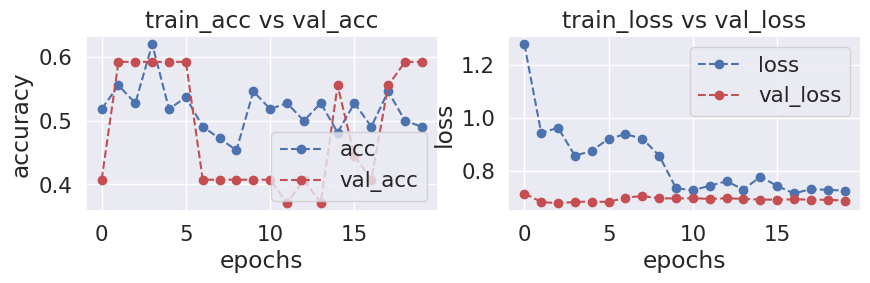

In [11]:

def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

plot_accuracy_loss(history)

In [12]:
predictions = model.predict(X_test)

# Convert the logits to probabilities
probabilities = tf.nn.softmax(predictions)

# Get the class with the highest probability
predicted_classes = np.argmax(probabilities, axis=1)

# Compare the predicted classes with the actual classes
comparison = list(zip(predicted_classes, y_test))

# Display the first 10 predictions and actual values
for i in range(10):
    print(f'Predicted: {predicted_classes[i]}, Actual: {y_test[i]}')

2/2 [==============================] - 2s 897ms/step
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0


In [13]:
test_loss, test_acc = model.evaluate(X_test,y_test)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)

2/2 [==============================] - 0s 21ms/step - loss: 0.6863 - accuracy: 0.6765
The test loss is:  0.6863055229187012
The best accuracy is:  67.64705777168274
